# Imports, Logging, and Setup

This section imports essential libraries and configures key components for the lightcurve extraction process.

## Key Components
1. **Imports**: 
   - Imports modules for file handling, data manipulation, visualization, and parallel processing.
2. **Logging**: 
   - Configures a logging system to record runtime information and errors in the `rxte_lightcurve.log` file.
3. **Custom Progress Bar**: 
   - Defines a custom lightweight progress bar function to avoid overhead from libraries like `tqdm`.
4. **Temporary Directory**: 
   - Sets up a shared memory directory (`/dev/shm`) for temporary file storage, improving file access speed.

These configurations form the foundation for the entire lightcurve extraction process.


In [1]:

# 📦 Imports
import sys, os, shutil
import glob
import pyvo as vo
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import datetime
import logging
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache
from IPython.display import display
import pandas as pd
import tempfile
import heasoftpy as hsp
from itertools import islice

# 🛠️ Configure Logging
logging.basicConfig(filename='rxte_lightcurve.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# 🕒 Start Timer
import time
start_time = time.time()

def simple_progress_bar(total, current, bar_length=30):
    """Custom progress bar to avoid tqdm overhead."""
    percent = current / total
    filled_length = int(bar_length * percent)
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    print(f'\r[{bar}] {percent*100:.2f}% ({current}/{total})', end='\r')

# 🗄️ Set up Temp Directory in Memory
os.environ['TMPDIR'] = '/dev/shm'


# Query for RXTE Observations

This section connects to the HEASARC TAP service and retrieves RXTE observation data for a specific target.

## Key Steps
1. **TAP Connection**: 
   - Connects to the HEASARC TAP service to access RXTE data.
2. **SQL Query**: 
   - Queries the RXTE database for observations, retrieving metadata like time, exposure, and observation ID. 
   - Computes the angular offset (in arcseconds) of each observation relative to the source position.
3. **Results Handling**: 
   - Tracks progress as query results are parsed and displays the results as a DataFrame.
4. **Plot Exposure**: 
   - Plots exposure vs. time to visualize the coverage and exposure times for each observation.

The combined query results are displayed in tabular form for further inspection.


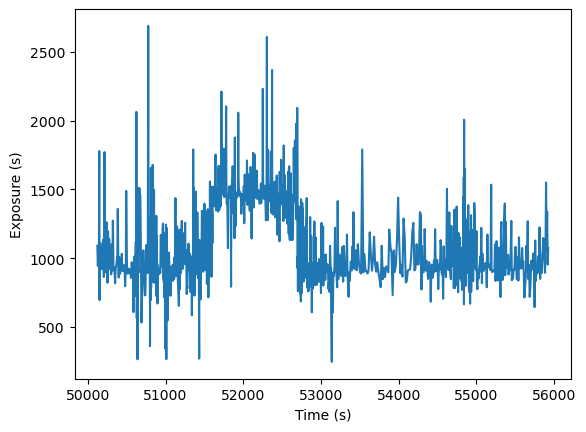

,target_name,cycle,prnb,obsid,time,exposure,ra,dec,offset_arcsec
0,ETA_CAR,1,10004,10004-01-40-00,50122.64263,1091.0,161.2583,-59.6800,28.242944
1,ETA_CAR,1,10004,10004-01-39-00,50129.42992,945.0,161.2583,-59.6800,28.242944
2,ETA_CAR,1,10004,10004-01-38-00,50134.57053,1018.0,161.2583,-59.6800,28.242944
3,ETA_CAR,1,10004,10004-01-41-00,50142.85058,958.0,161.2583,-59.6800,28.242944
4,ETA_CAR,1,10004,10004-01-37-00,50147.83134,1778.0,161.2583,-59.6800,28.242944
...,...,...,...,...,...,...,...,...,...
1363,ETA_CAR,15,96002,96002-01-48-00,55895.66810,1550.0,161.2650,-59.6845,0.850091
1364,ETA_CAR,15,96002,96002-01-49-00,55902.51077,1137.0,161.2650,-59.6845,0.850091
1365,ETA_CAR,15,96002,96002-01-50-00,55909.92591,1339.0,161.2650,-59.6845,0.850091
1366,ETA_CAR,15,96002,96002-01-51-00,55916.80008,954.0,161.2650,-59.6845,0.850091


In [2]:
# 🌐 Connect to TAP Service
tap_services = vo.regsearch(servicetype='tap', keywords=['heasarc'])
heasarc_tables = tap_services[0].service.tables

# 🔭 Get the Coordinate for GRS 1915+105
pos = SkyCoord.from_name("eta car")

# 📋 SQL Query for RXTE Data (Includes Offset Calculation)
query = f"""
SELECT target_name, cycle, prnb, obsid, time, exposure, ra, dec, 
    sqrt(power(cat.ra - {pos.ra.deg}, 2) + power(cat.dec - {pos.dec.deg}, 2)) * 3600 as offset_arcsec
FROM public.xtemaster as cat 
WHERE 
    contains(point('ICRS', cat.ra, cat.dec), circle('ICRS', {pos.ra.deg}, {pos.dec.deg}, 0.1)) = 1 
    AND cat.exposure > 0 
ORDER BY cat.time
"""

# 📊 Query Results
results = tap_services[0].search(query).to_table()

# 🖼️ Custom Progress Bar for Parsing Query Results
total_rows = len(results)
for i, row in enumerate(results):
    simple_progress_bar(total_rows, i + 1)  # Update progress bar

# 🖼️ Plot Exposure vs Time
plt.plot(results['time'], results['exposure'])
plt.xlabel('Time (s)')
plt.ylabel('Exposure (s)')
plt.show()

# 📋 Display Full Query Results
results_df = results.to_pandas()
display(results_df)


# File Handling and Validation

This section generates file paths for RXTE data files corresponding to the observations retrieved from the TAP query.

## Key Steps
1. **File Path Generation**: 
   - Creates paths for RXTE data files corresponding to the metadata of each observation.
2. **File Existence Check**: 
   - Uses multi-threaded file existence checks to identify missing files.
3. **File Validation**: 
   - Filters out missing files, ensuring only valid files are retained for further processing.
4. **Progress Tracking**: 
   - Tracks the progress of file checks using a progress bar.

Only valid RXTE files are retained, allowing for efficient downstream processing.


In [3]:
from concurrent.futures import ThreadPoolExecutor

def check_file_exists(path):
    """Check if file exists in a multi-threaded pool."""
    return path if os.path.exists(path) else None

rxtedata = "/FTP/rxte/data/archive"
filenames = [
    f"{rxtedata}/AO{cycle}/P{prnb}/{obsid}/stdprod/xp{obsid.replace('-', '')}_n2a.lc.gz"
    for cycle, prnb, obsid in zip(results['cycle'], results['prnb'], results['obsid'])
]

# Check in parallel for missing files
total_files = len(filenames)
valid_files = []

with ThreadPoolExecutor(max_workers=16) as executor:
    for i, file in enumerate(executor.map(check_file_exists, filenames)):
        if file: 
            valid_files.append(file)
        simple_progress_bar(total_files, i + 1)  # Update progress bar

filenames = [file for file in valid_files if file]
print(f"\nFound {len(filenames)} files out of {len(results)} observations.")


[██████████████████████████████] 100.00% (1368/1368)
Found 1364 files out of 1368 observations.


# Load and Plot Intermediate Lightcurves

This section loads lightcurve data from valid RXTE FITS files and visualizes the results.

## Key Steps
1. **FITS Data Loading**: 
   - Uses `astropy.io.fits` to read lightcurve data from the second header of each FITS file.
2. **Parallel Processing**: 
   - Loads multiple FITS files concurrently using a thread pool for faster execution.
3. **Error Handling**: 
   - Catches and logs errors that occur while loading individual FITS files.
4. **Plot Lightcurves**: 
   - Plots all intermediate lightcurves to visually inspect data quality and ensure completeness.

This process allows for rapid data loading, with intermediate plots providing a visual reference for data integrity.


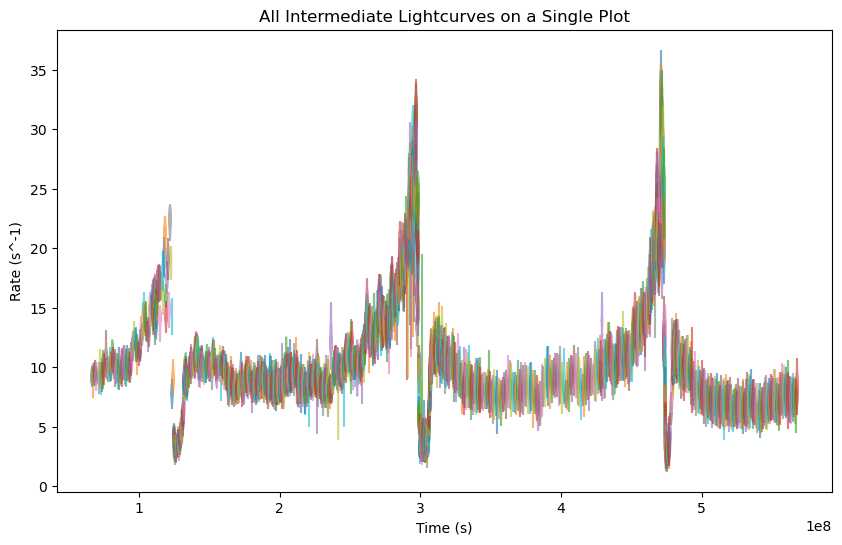

In [4]:

def load_and_plot_fits_file(file, i, total_files):
    """Load a FITS file and return its lightcurve data."""
    try:
        with fits.open(file) as hdul:
            data = hdul[1].data  # Extract lightcurve data from the second header
        simple_progress_bar(total_files, i + 1)  # Update progress bar
        return data  # Return the lightcurve data
    except Exception as e:
        logging.error(f"Failed to load file {file}: {e}")
        return None

# 🔥 Load Lightcurves Using Threads
lcurves = []
total_files = len(filenames)

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = {executor.submit(load_and_plot_fits_file, file, i, total_files): file for i, file in enumerate(filenames)}
    for i, future in enumerate(futures):
        simple_progress_bar(total_files, i + 1)  # Update progress bar
        result = future.result()
        if result is not None:
            lcurves.append(result)

# 🖼️ Plot All Intermediate Lightcurves on a Single Plot
plt.figure(figsize=(10, 6))
for i, data in enumerate(lcurves):
    plt.plot(data['TIME'], data['RATE'], alpha=0.6)  # Plot each lightcurve with slight transparency
plt.xlabel('Time (s)')
plt.ylabel('Rate (s^-1)')
plt.title('All Intermediate Lightcurves on a Single Plot')
plt.show()


# Concatenate and Plot Final Lightcurve

This section concatenates individual lightcurves into a single lightcurve and visualizes the final result.

## Key Steps
1. **Concatenate Lightcurves**: 
   - Combines all individual lightcurves into a single, unified lightcurve using NumPy.
2. **Sort Lightcurve**: 
   - Sorts the combined lightcurve by the 'TIME' column to maintain chronological order.
3. **Plot Final Lightcurve**: 
   - Plots the final combined lightcurve to visualize the full set of RXTE observations.

The final lightcurve provides a complete view of the combined RXTE observations, making it ready for further analysis.


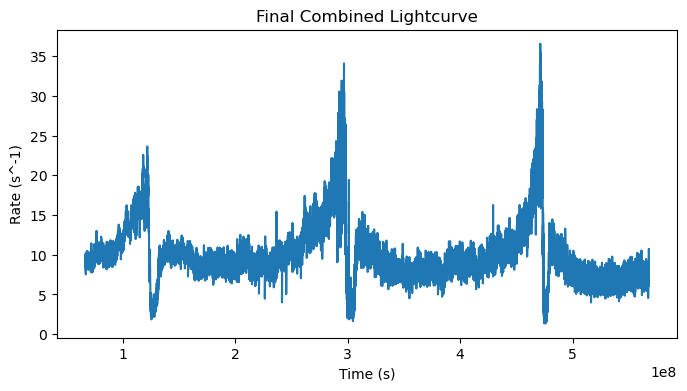

In [5]:
# 🧮 Combine Lightcurves (Use NumPy Instead of Numba)
def concatenate_lightcurves(lcurves):
    """Concatenate lightcurves more efficiently."""
    return np.concatenate(lcurves)

lcurve = concatenate_lightcurves(lcurves)

# 🖼️ Plot Final Lightcurve
plt.figure(figsize=(8, 4))
plt.plot(lcurve['TIME'], lcurve['RATE'])
plt.xlabel('Time (s)')
plt.ylabel('Rate (s^-1)')
plt.title('Final Combined Lightcurve')
plt.show()


# RXTE Lightcurve Extraction Functions

This section defines key functions for extracting lightcurves from RXTE data.

## Key Functions
- **XlcError**: Custom exception to handle RXTE-specific errors. 
- **rxte_lc**: Extracts RXTE lightcurve for a given observation (ObsID) using HEASoft utilities. 
  - **Temporary Directory**: Creates a temporary directory for intermediate files. 
  - **File Handling**: Extracts filtered data from `.xfl` and `.lc` files. 
  - **Automatic Cleanup**: Temporary files are automatically deleted after extraction. 
- **rxte_lc_wrapper**: A wrapper function to facilitate parallel processing of RXTE lightcurve extraction. 
  - **Error Handling**: Ensures that errors are caught and logged. 
  - **Multiprocessing Ready**: Designed for use in multiprocessing workflows. 


In [6]:
# 🚀 RXTE Lightcurve Extraction Functions
class XlcError(Exception):
    """Custom exception for RXTE Lightcurve errors."""
    pass


def rxte_lc(obsid, ao, chmin=5, chmax=10, cleanup=True):
    """Extract RXTE lightcurve for a given ObsID."""
    import tempfile  # ✅ Re-import here for multiprocessing
    outdir = tempfile.mkdtemp(prefix=f"tmp.{obsid}.")
    obsdir = f"/FTP/rxte/data/archive/AO{ao}/P{obsid[:5]}/{obsid}/"
    try:
        result = hsp.pcaprepobsid(indir=obsdir, outdir=outdir)
        
        filt_files = glob.glob(f"{outdir}/FP_*.xfl")
        if not filt_files:
            available_files = glob.glob(f"{outdir}/*")
            logging.error(f"No FP_*.xfl file found for ObsID {obsid} in {outdir}. Available files: {available_files}")
            raise XlcError(f"Failed to find FP_*.xfl for ObsID {obsid}")
        
        filt_file = filt_files[0]

        result = hsp.maketime(infile=filt_file, outfile=os.path.join(outdir, 'rxte_example.gti'), 
                              expr="(ELV > 4) && (OFFSET < 0.1)", name='NAME', value='VALUE', time='TIME', compact='NO')

        result = hsp.pcaextlc2(src_infile=f"@{outdir}/FP_dtstd2.lis", bkg_infile=f"@{outdir}/FP_dtbkg2.lis", 
                               outfile=os.path.join(outdir, 'rxte_example.lc'), 
                               gtiandfile=os.path.join(outdir, 'rxte_example.gti'), 
                               chmin=chmin, chmax=chmax, pculist='ALL', layerlist='ALL', binsz=16)

        lc_path = os.path.join(outdir, 'rxte_example.lc')

        if not os.path.exists(lc_path):
            logging.error(f"Lightcurve file {lc_path} not found for ObsID {obsid}")
            raise FileNotFoundError(f"rxte_example.lc not found for ObsID {obsid} in {outdir}")

        with fits.open(lc_path) as hdul:
            lc = hdul[1].data

        return lc

    except Exception as e:
        logging.error(f"Error processing ObsID {obsid}: {e}")
        return None  # Return None if an error occurs

    finally:
        shutil.rmtree(outdir, ignore_errors=True)


def rxte_lc_wrapper(pars):
    """Wrapper for RXTE lightcurve extraction to be used in multiprocessing."""
    obsid, ao, chmin, chmax, cleanup, progress, lock = pars  # Added progress and lock
    try:
        lc = rxte_lc(obsid, ao, chmin, chmax, cleanup)
    except Exception as e:
        logging.error(f"Error in rxte_lc_wrapper for ObsID {obsid}: {e}")
        print(f"Error in rxte_lc_wrapper for ObsID {obsid}: {e}")
        lc = None  # Return None to continue processing
    finally:
        with lock:  # 🛠️ Use a shared lock to ensure thread-safe progress update
            progress.value += 1  # Safely increment the shared counter
    return lc


# Extract and Combine Lightcurves from Sample Observations

This section processes the first 10 RXTE observations as a demonstration.

## Key Steps
1. **Observation Limit**: Limits the number of observations to 10 for demonstration or testing.
2. **Lightcurve Extraction**: Extracts lightcurves for each observation using `rxte_lc`. 
3. **Plot Each Lightcurve**: Plots each lightcurve for visual inspection.
4. **Combine Lightcurves**: Uses `align_and_concatenate_lcurves` to create a unified lightcurve.
5. **Final Plot**: The combined lightcurve from the first 10 observations is plotted.

## Note
This demonstration is useful for testing purposes, allowing users to visually inspect intermediate results 
and check the integrity of the combined lightcurve.


Error during final lightcurve combination or plotting: name 'align_and_concatenate_lcurves' is not defined


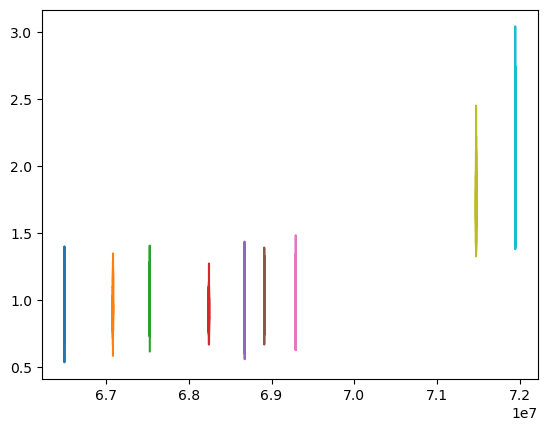

In [7]:
# 🕹️ Limit the number of observations to 10 as per the tutorial
nlimit = 10
total_obs = len(results[:nlimit])
lcurves = []

# 🕹️ Loop through the first `nlimit` observations and extract lightcurves sequentially
for i, val in enumerate(results[:nlimit]):
    simple_progress_bar(total_obs, i + 1)  # Update progress bar for observation load
    try:
        lc = rxte_lc(obsid=val['obsid'], ao=val['cycle'], chmin=5, chmax=10, cleanup=True)
        if lc is not None:
            lcurves.append(lc)  # Store only non-None lightcurves
            plt.plot(lc['TIME'], lc['RATE'])  # Plot each individual lightcurve
    except Exception as e:
        logging.error(f"Failed to extract lightcurve for ObsID {val['obsid']}: {e}")
        print(f"Failed to extract lightcurve for ObsID {val['obsid']}: {e}")

# 🔗 Align and Concatenate Lightcurves (Handles Field Mismatches)
if lcurves:
    try:
        lcurve = align_and_concatenate_lcurves(lcurves)  # Call the new alignment function
        lcurve.sort(order='TIME')  # Sort the lightcurve by TIME
        plt.figure(figsize=(8, 4))
        plt.plot(lcurve['TIME'], lcurve['RATE'])
        plt.xlabel('Time (s)')
        plt.ylabel('Rate ($s^{-1}$)')
        plt.title('Combined Lightcurve from First 10 Observations')
        plt.show()
    except Exception as e:
        logging.error(f"Error during final lightcurve combination or plotting: {e}")
        print(f"Error during final lightcurve combination or plotting: {e}")
else:
    logging.error("No lightcurves to combine.")
    print("No lightcurve to plot.")


# Align and Concatenate Lightcurves

This section aligns and concatenates individual lightcurves while ensuring that all fields are retained.

## Key Steps
1. **Field Alignment**: 
   - Identifies the set of all unique field names across the lightcurves. 
   - Aligns each lightcurve to this unified set of fields, filling missing fields with zeros. 
2. **Concatenation**: 
   - Combines all aligned lightcurves into a single structured array for further analysis.

## Purpose
The alignment process ensures that lightcurves with mismatched fields (caused by missing columns) 
are properly aligned, allowing for seamless concatenation.


In [8]:
# 🧮 Concatenate Lightcurves While Retaining All Fields
def align_and_concatenate_lcurves(lcurves):
    """Align fields in all lightcurves and concatenate them."""
    # 🔍 Find the union of all field names in the lightcurves
    all_fields = set()
    for lc in lcurves:
        all_fields.update(lc.dtype.names)
    
    all_fields = sorted(all_fields)

    aligned_lcurves = []
    for i, lc in enumerate(lcurves):
        current_fields = lc.dtype.names  # Fields present in the current lightcurve
        new_dtype = [(field, lc.dtype[field]) if field in current_fields else (field, 'f8') for field in all_fields]
        
        # Create an empty structured array with the new dtype
        new_lc = np.zeros(lc.shape, dtype=new_dtype)
        
        for field in lc.dtype.names:
            new_lc[field] = lc[field]
        
        aligned_lcurves.append(new_lc)
    
    concatenated_lcurve = np.concatenate(aligned_lcurves)
    return concatenated_lcurve

# Parallel Extraction of RXTE Lightcurves

This section extracts RXTE lightcurves in parallel using multiprocessing to improve speed and efficiency.

## Key Steps
1. **Multiprocessing Pool**: Extracts lightcurves for up to 64 observations concurrently.
2. **Parallel Execution**: Uses `mp.Pool` to execute lightcurve extraction across multiple CPU cores. 
3. **Progress Tracking**: Uses a progress bar to track the status of each extraction.
4. **Result Handling**: Stores successfully extracted lightcurves in a list for further processing.

## Purpose
This approach significantly reduces the overall runtime for large datasets, as multiple observations 
are processed in parallel. Results are available as soon as each process finishes.


In [9]:
# 🔥 Parallel Extraction of RXTE Lightcurves with Shared Progress Tracking
nlimit = 64
ncpu = min(mp.cpu_count(), 16)  # Limit the number of CPUs
total_obs = len(list(islice(results, nlimit)))  # Total number of observations to be processed
manager = mp.Manager()
progress = manager.Value('i', 0)  # Shared counter to track progress
lock = manager.Lock()  # Lock for thread-safe updates to progress

# 🗂️ Generate parameters for pool
pars = [[val['obsid'], val['cycle'], 5, 10, True, progress, lock] for val in islice(results, nlimit)]  # Pass progress & lock

# 🛠️ Use imap_unordered to get results as they complete
lcs = []  # Store all successfully extracted lightcurves
with mp.Pool(processes=ncpu) as pool:
    for lc in pool.imap_unordered(rxte_lc_wrapper, pars):  # Using imap_unordered for early results
        if lc is not None:
            lcs.append(lc)  # Only store non-None lightcurves
        
        # 📈 Progress bar for shared progress tracking
        simple_progress_bar(total_obs, progress.value)  # Update the progress bar

# Filter, Combine, and Plot Final Lightcurve

This section processes the extracted lightcurves to produce a final, unified result.

## Key Steps
1. **Filter Lightcurves**: 
   - Filters out invalid lightcurves (None values) to ensure only valid data is processed.
2. **Combine Lightcurves**: 
   - Uses `align_and_concatenate_lcurves` to combine all valid lightcurves into one.
3. **Sort Lightcurve**: 
   - Sorts the final lightcurve by the 'TIME' column.
4. **Plot Final Result**: 
   - Plots the final combined lightcurve, providing a complete view of the RXTE observations.

## Note
If no valid lightcurves are found, an error is logged, and no plot is displayed.


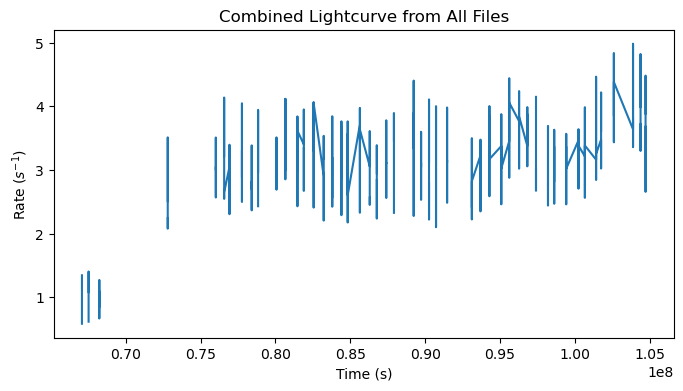

In [10]:
# 🧹 Filter out None values from lightcurves
lcs = [lc for lc in lcs if lc is not None]

# 🧮 Combine and Sort Lightcurves
if lcs:
    lcurve = align_and_concatenate_lcurves(lcs)  # Align and combine all lightcurves into one
    lcurve.sort(order='TIME')  # Sort the lightcurve by TIME
else:
    logging.error("No lightcurves to combine.")
    lcurve = None

# 🖼️ Plot Final Lightcurve
if lcurve is not None:
    plt.figure(figsize=(8, 4))
    plt.plot(lcurve['TIME'], lcurve['RATE'])
    plt.xlabel('Time (s)')
    plt.ylabel('Rate ($s^{-1}$)')
    plt.title('Combined Lightcurve from All Files')
    plt.show()
else:
    logging.error("No lightcurve to plot.")

# Log Total Execution Time

This section calculates the total runtime for the lightcurve extraction process.

## Key Steps
1. **Timing**: 
   - Captures the start and end times to compute the total runtime.
2. **Logging**: 
   - Logs the total runtime in the `rxte_lightcurve.log` file for future reference.
3. **Display**: 
   - Prints the total runtime to the console for reference.

## Purpose
This provides insight into the overall processing time, allowing for performance analysis and future optimization.


In [11]:

# 🕒 Log the Total Execution Time
end_time = time.time()
total_time = end_time - start_time
logging.info(f"Total runtime: {total_time} seconds")
print(f"Total runtime: {total_time:.2f} seconds")


Total runtime: 305.17 seconds
